## Value-at-Risk: Using Filtered Historical Simulation

**Functions**

`arch_model`, `ARCHModelResult.std_resid`

### Exercise 59
Use a GARCH(1,1) model to construct filtered historical VaR for the S&P 500 and the EUR/USD exchange rate, using 10 years of data.

**Note**: For simplicity, estimate the model on the full sample, but start the historical simulation at 25% of the data, and
then build the additional forecasts using a recursive scheme.

In [92]:
%matplotlib inline
from arch import arch_model
import pandas as pd
import numpy as np
sp500 = pd.read_hdf("./data/arch-data.h5", "sp500")        
eurusd = pd.read_hdf("./data/arch-data.h5", "eurusd")

sp500_returns = 100 * sp500.SP500.pct_change().dropna()
eurusd_returns = 100 * eurusd.DEXUSEU.pct_change().dropna()

mod = arch_model(sp500_returns)
res = mod.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3014.5904796994937
Iteration:      2,   Func. Count:     16,   Neg. LLF: 3012.5320163673546
Iteration:      3,   Func. Count:     25,   Neg. LLF: 3010.801852261159
Iteration:      4,   Func. Count:     34,   Neg. LLF: 3008.514323297097
Iteration:      5,   Func. Count:     41,   Neg. LLF: 2998.34678892632
Iteration:      6,   Func. Count:     48,   Neg. LLF: 2998.1375359845188
Iteration:      7,   Func. Count:     54,   Neg. LLF: 2997.091706804308
Iteration:      8,   Func. Count:     60,   Neg. LLF: 2997.0652133388126
Iteration:      9,   Func. Count:     66,   Neg. LLF: 2997.0613460443938
Iteration:     10,   Func. Count:     72,   Neg. LLF: 2997.060737138707
Iteration:     11,   Func. Count:     78,   Neg. LLF: 2997.060725515726
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2997.060725516014
            Iterations: 11
            Function evaluations: 78
            Gradient evaluation

C:\Anaconda\envs\anaconda-core\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.8663. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)


In [93]:
std_resid: pd.Series = res.std_resid
forecasts = res.forecast(start=sp500_returns.index[0])

start = int(0.25 * std_resid.shape[0])
std_quantile = std_resid.expanding(min_periods=start).quantile(0.05)


mu = res.params.mu
sigma = np.sqrt(forecasts.variance["h.1"])
q = std_quantile

var_1step = -mu - sigma * q
# Fix alignment since both q and sigma are aligned at time when produced
var_1step = var_1step.shift(1).dropna()

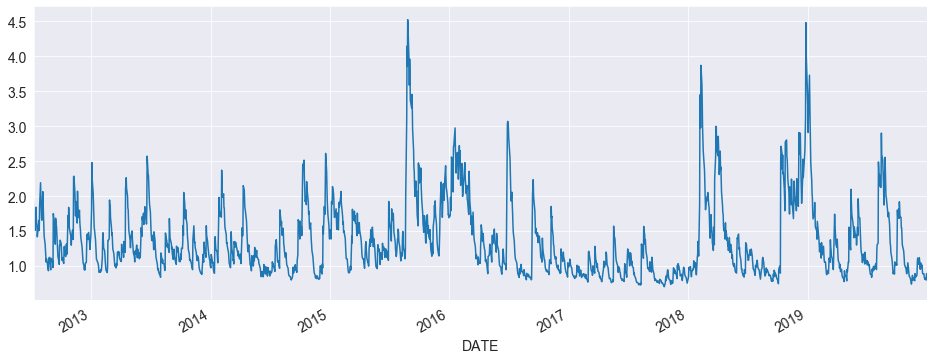

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.rc("figure",figsize=(16,6))
plt.rc("font",size=14)
fig, ax = plt.subplots(1,1)
var_1step.plot(ax=ax)

Multi-step VaR is harder.  We need to simulate $h$ days and then take the quantile
of the simulated forecasts. While `arch` can do this for us, it is instructive to
manually implement the steps. We will start with a single day, and then wrap that 
in a loop to compute the 5-day VaR for the entire sample.

In [95]:
rs = np.random.RandomState([738492843,438248394])
j = start
variances = np.empty((1000, 5))
sim_eps = np.empty((1000,5))
mu, omega, alpha, beta = res.params
for i in range(5):
    sim_e = rs.choice(res.std_resid.iloc[:j],size=1000)
    if i== 0:
        variances[:,0] = res.conditional_volatility.iloc[j] ** 2
    else:
        variances[:,i] = omega + alpha * sim_eps[:,i-1]**2 + beta * variances[:,i-1]
    sim_eps[:,i] = np.sqrt(variances[:,i]) * sim_e
sim_rets = mu + sim_eps
rets_5 = sim_rets.sum(1)

fhs_var = -np.percentile(rets_5, 5)
fhs_var

3.998222320803734

In [96]:
nobs =sp500_returns.shape[0]
var_5step = np.full(nobs, np.nan)
for j in range(start, nobs):
    if j % 250 == 0:
        print(f"Remaining: {nobs - j}")
    sub_std_resid = res.std_resid.iloc[:j]
    sigma2_t = res.conditional_volatility.iloc[j] ** 2
    for i in range(5):
        sim_e = rs.choice(sub_std_resid,size=1000)
        if i== 0:
            variances[:,0] = sigma2_t
        else:
            variances[:,i] = omega + alpha * sim_eps[:,i-1]**2 + beta * variances[:,i-1]
        sim_eps[:,i] = np.sqrt(variances[:,i]) * sim_e
    sim_rets = mu + sim_eps
    rets_5 = sim_rets.sum(1)
    var_5step[j] = -np.percentile(rets_5, 5)

Remaining: 1760
Remaining: 1510
Remaining: 1260
Remaining: 1010
Remaining: 760
Remaining: 510
Remaining: 260
Remaining: 10


In [97]:
var_5step = pd.Series(var_5step, index=sp500_returns.index)
var_5step = var_5step.shift(5)

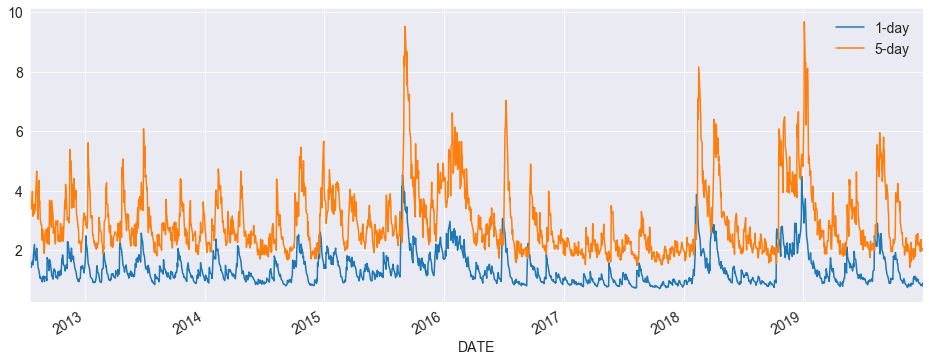

In [98]:
value_at_risks = pd.concat([var_1step, var_5step],axis=1).dropna()
value_at_risks.columns=["1-day","5-day"]
value_at_risks.plot(legend=False)
plt.legend(frameon=False)

In [99]:
def fhs_var(params, std_resid, cond_variances, loc, random_state, horizon):
    variances = np.empty((1000, horizon))
    sim_eps = np.empty((1000, horizon))
    mu, omega, alpha, beta = params 

    for i in range(horizon):
        sim_e = random_state.choice(std_resid.iloc[:loc],size=1000)
        if i == 0:
            variances[:,0] = cond_variances.iloc[loc] ** 2
        else:
            variances[:,i] = omega + alpha * sim_eps[:,i-1]**2 + beta * variances[:,i-1]
        sim_eps[:,i] = np.sqrt(variances[:,i]) * sim_e
    sim_rets = mu + sim_eps
    rets_horizon = sim_rets.sum(1)
    return -np.percentile(rets_horizon, 5)

In [100]:
var_10step = np.full(nobs, np.nan)
cond_var = res.conditional_volatility ** 2
horizon = 10
for loc in range(start, nobs):
    if loc % 250 == 0:
        print(f"Remaining: {nobs - loc}")
    var_10step[loc] = fhs_var(res.params, res.std_resid, cond_var, loc, rs, horizon)

Remaining: 1760
Remaining: 1510
Remaining: 1260
Remaining: 1010
Remaining: 760
Remaining: 510
Remaining: 260
Remaining: 10


In [101]:
var_10step = pd.Series(var_10step, index=sp500_returns.index)
var_10step = var_10step.shift(10)

Text(0.5, 1.0, 'S&P 500 Filtered Historical Simulation VaR')

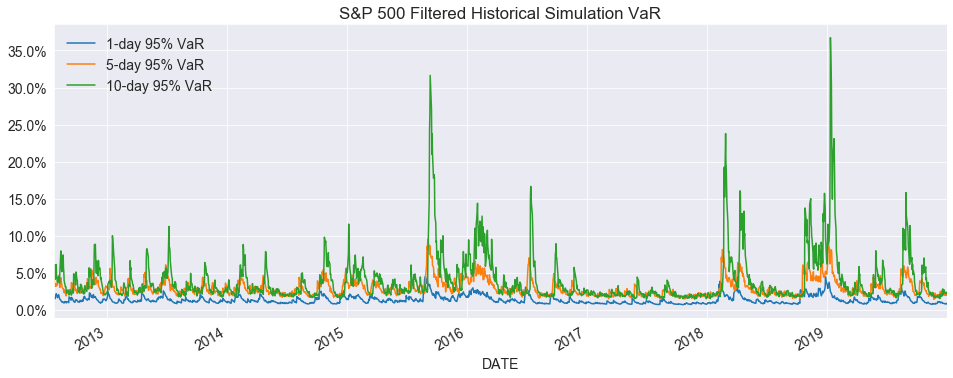

In [102]:
value_at_risks = pd.concat([var_1step, var_5step, var_10step],axis=1).dropna()
value_at_risks.columns=["1-day 95% VaR","5-day 95% VaR","10-day 95% VaR"]
ax = value_at_risks.plot(legend=False)
plt.legend(frameon=False)
ax.set_yticklabels([f"{tick}%" for tick in ax.get_yticks()])
ax.set_title("S&P 500 Filtered Historical Simulation VaR")

### Exercise 60

Compare this VaR to the HS VaR in the previous example.

In [103]:
mod = arch_model(eurusd_returns)
res = mod.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1909.670911265314
Iteration:      2,   Func. Count:     16,   Neg. LLF: 1909.624029248601
Iteration:      3,   Func. Count:     25,   Neg. LLF: 1909.5927218523254
Iteration:      4,   Func. Count:     32,   Neg. LLF: 1899.5314975665528
Iteration:      5,   Func. Count:     38,   Neg. LLF: 1890.8762765427095
Iteration:      6,   Func. Count:     45,   Neg. LLF: 1887.7773933380681
Iteration:      7,   Func. Count:     55,   Neg. LLF: 1886.4594708340137
Iteration:      8,   Func. Count:     64,   Neg. LLF: 1886.4590654686854
Iteration:      9,   Func. Count:     71,   Neg. LLF: 1886.4329318801788
Iteration:     10,   Func. Count:     77,   Neg. LLF: 1886.4203363174297
Iteration:     11,   Func. Count:     83,   Neg. LLF: 1886.4203040415516
Iteration:     12,   Func. Count:     89,   Neg. LLF: 1886.4203000155449
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1886.4203000140574
            Iter

C:\Anaconda\envs\anaconda-core\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.3051. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)


In [104]:
cond_var = res.conditional_volatility ** 2
eurusd_var = {}
nobs = eurusd_returns.shape[0]
start = int(0.25 * nobs)
index = eurusd_returns.index
for horizon in (1,5, 10):
    temp = np.full(nobs, np.nan)
    for loc in range(start, nobs):
        if loc % 500 == 0:
            print(f"Horizon: {horizon}, Remaining: {nobs - loc}")
        temp[loc] = fhs_var(res.params, res.std_resid, cond_var, loc, rs, horizon)
    eurusd_var[f"{horizon}-day 95%-VaR"] = pd.Series(temp, index=index)
eurusd_var = pd.DataFrame(eurusd_var).dropna()

Horizon: 1, Remaining: 1501
Horizon: 1, Remaining: 1001
Horizon: 1, Remaining: 501
Horizon: 1, Remaining: 1
Horizon: 5, Remaining: 1501
Horizon: 5, Remaining: 1001
Horizon: 5, Remaining: 501
Horizon: 5, Remaining: 1
Horizon: 10, Remaining: 1501
Horizon: 10, Remaining: 1001
Horizon: 10, Remaining: 501
Horizon: 10, Remaining: 1


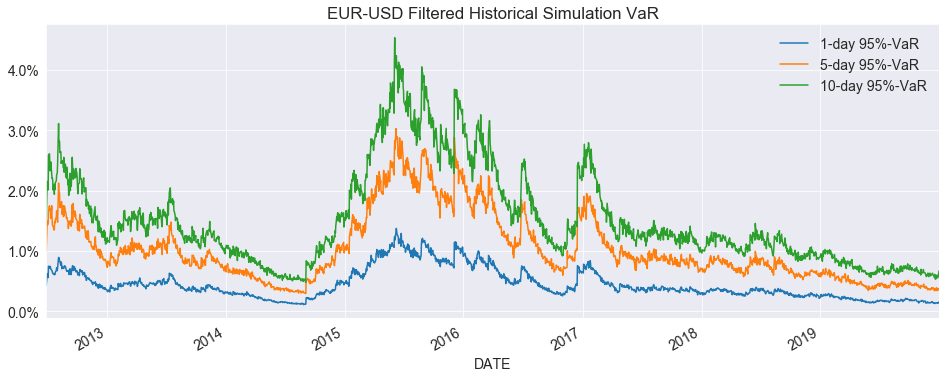

In [105]:
ax = eurusd_var.plot(legend=False)
plt.legend(frameon=False)
ax.set_yticklabels([f"{tick}%" for tick in ax.get_yticks()])
title = ax.set_title("EUR-USD Filtered Historical Simulation VaR")